# How to Replicate Figure 1A

## Some Prerequisites

This is the primary formula for figure 1A (just so you won't have to look between the paper and here):

In [1]:
%%latex
$$f_{k}(t) = \left[10+\sum_{j=1}^{40}\sum_{l=-\infty}^{\infty}\frac{1}{2\sigma/\sqrt{2}}\exp\left(-\frac{|t+l-\mu_{j,k}|}{\sigma/\sqrt{2}}\right)\right]\mathbb{1}\{t\in[0,1)\}$$

<IPython.core.display.Latex object>

Necessary modules that are imported. The * actually is there so one doesn't have to write the modulename.function(), but instead just the function. This feature is exclusive to mpmath and sympy as far as I know. Of course, the random seed is there so that the same random numbers pop up.

In [1]:
import numpy as np 
from mpmath import *
from sympy import *
import matplotlib.pyplot as plt
from sympy.utilities.autowrap import binary_function
np.random.seed(100000) # random.seed can take in any numeric parameter (I just put 100k because it's my fav number)

Generate 40 samples from the uniform distribution on the intervale [0,1)

In [2]:
ulist = np.random.uniform(size=40)
print(ulist) 
print(type(ulist)) # just to show the type 
print(ulist[-1]) # computers start counting at zero so the 40th entry will be the length minus 1

[0.28756086 0.50824819 0.49804102 0.78166945 0.12240347 0.28985739
 0.02718451 0.56698733 0.46840546 0.48920149 0.91172657 0.64116351
 0.40222002 0.08719419 0.70591666 0.43552118 0.22127919 0.80953517
 0.64539098 0.44845518 0.9796147  0.22248977 0.42494292 0.3725055
 0.92901398 0.17755212 0.86975187 0.80312425 0.31092782 0.2477964
 0.91274724 0.88823599 0.18996868 0.85151296 0.30399936 0.42124902
 0.23817261 0.08061116 0.30040369 0.85970508]
<class 'numpy.ndarray'>
0.8597050837555236


## The Math Behind the Code

The motivation behind this mess is due to the fact that when you do lambda inside the nsum function, it can't have another symbolic variable t0 because it will confuse the heck out of python, so best to extract it. Luckily we're working with exponential function, so we can get past that mental block. 

The exponential function has an absolute value so we can decompose it as follows:

In [4]:
%%latex

\[\exp\left(-\frac{|t+l-\mu_{j,k}|}{\sigma/\sqrt{2}}\right) =   \left\{
\begin{array}{ll}
      \exp\left(-\frac{\mu_{j,k}-(t+l)}{\sigma/\sqrt{2}}\right) & \textrm{if }t+l<\mu_{j,k}\textrm{ or (equivalently) }l<\mu_{j,k}-t\\
      \exp\left(-\frac{(t+l)-\mu_{j,k}}{\sigma/\sqrt{2}}\right)& \textrm{if }t+l\geq\mu_{j,k}\textrm{ or (equivalently) }l\geq\mu_{j,k}-t \\
\end{array} 
\right. \]

<IPython.core.display.Latex object>

It is important to mention that $\mu_{j,k}\in[0,1)$, since it's taken from a uniform distribution on $[0,1)$, and that also $t\in[0,1)$, due to the indicator function. This is an important realization because:

In [5]:
%%latex

$$l\geq\mu_{j,k}-t\textrm{  is true  }\forall\textrm{  } l\geq 1 \textrm{  since  } l\geq\max_{t,\mu_{j,k}\in[0,1)}[\mu_{j,k}-t]=0.\bar{9}$$
$$l<\mu_{j,k}-t\textrm{  is true  }\forall\textrm{  } l\leq -1 \textrm{  since  } l<\min_{t,\mu_{j,k}\in[0,1)}[\mu_{j,k}-t]=-0.\bar{9}$$

<IPython.core.display.Latex object>

We break up the $-\infty$ to $\infty$ summation to a $l=1$ to $\infty$ summation and keep the exponential version for which the first (lax) inequality holds true (this is term 1, for reference in the code below). We also make a $-\infty$ to $l=-1$ summation and keep the exponential version for which the second (strict) inequality holds true (this is term 2, for reference in the code below). This leaves us with the conditional term when $l=0$, denoted my function $L$. I call this term conditional because it actually depends on what values $\mu_{j,k}$ and $t$ take. 

In [6]:
%%latex
$$f_{k}(t) = 10 + \frac{1}{\sigma\sqrt{2}}\sum_{j=1}^{40}\left[\sum_{l=1}^{l=\infty}\exp\left(
    -\frac{(t+l)-\mu_{j,k}}{\sigma/\sqrt{2}}\right)+L(l=0)+\sum_{l=-\infty}^{l=-1}
    \exp\left(-\frac{\mu_{j,k}-(t+l)}{\sigma/\sqrt{2}}\right)\right]\mathbb{1}\{t\in[0,1)\}$$

<IPython.core.display.Latex object>

Playing around with the negative signs and extracting exponentials gives:

In [7]:
%%latex
$$f_{k}(t) = 10 + \frac{1}{\sigma\sqrt{2}}\sum_{j=1}^{40}\left[
\overbrace{\exp\left(\frac{\mu_{j,k}-t}{\sigma/\sqrt{2}}\right)\sum_{l=1}^{l=\infty}\exp\left(-\frac{l}{\sigma/\sqrt{2}}\right)}
^{\text{term 1}}+\overbrace{L(l=0)}^{\text{1 conditional term}}+\overbrace{\exp\left(\frac{t-\mu_{j,k}}{\sigma/\sqrt{2}}\right)
\sum_{l=-\infty}^{l=-1}\exp\left(\frac{l}{\sigma/\sqrt{2}}\right)}^{\text{term 2}}
\right]\mathbb{1}\{t\in[0,1)\}$$

<IPython.core.display.Latex object>

Term 1 and term 2 are not that bad. Sympy's nsum can elegantly calculate the infinite sum without fiddling with approximations. Unfortunately, we have to create an if loop to determine what expression $L(l=0)$ will take. 

The following block of latex code shows how the conditional term $L(l=0)$ varies. Notice we substituted the appropriate value of zero for $l$ to make the inequalities between $t$ and $\mu_{j,k}$, only.

In [8]:
%%latex
\[L(l=0) = \left\{
\begin{array}{ll}
    \textrm{$B_1$ condition: if  }t\geq\mu_{j,k}\rightarrow & \exp\left(\frac{\mu_{j,k}-t}{\sigma/\sqrt{2}}\right) \\
    \textrm{$B_2$ condition: else if  }t<\mu_{j,k}\rightarrow & \exp\left(\frac{t-\mu_{j,k}}{\sigma/\sqrt{2}}\right) \\
\end{array} 
\right. \]

<IPython.core.display.Latex object>

## The Function Translated into Code
Because of the explanations detailed previously, the following code should be self-explanatory. If you want a reference: sqrt and exp belongs to sympy, while nsum belongs to mpmath.

In [3]:
sigma = 0.05 # The paper gives this value for sigma, the bandwidth or standard deviation

somelist = [] # preparing an empty list for use by the function; lists are important 
              # because you can access their entries easily.

def fsubk(t0): 
    somelist.clear() # This is very important. Every call to the function (see below) must 
                     # have the 'something' list cleared. The clear method does that without deleting 
                     # the list entirely.
    for i in range(0,len(ulist)): # For range(a,b) python counts anything in the integer wide set [a,b-1]
        somelist.append(float(exp((ulist[i]-t0)/(sigma/sqrt(2)))*nsum(lambda k: exp(-k/(sigma/sqrt(2))),[1,inf]))) # term 1
        somelist.append(float(exp((t0-ulist[i])/(sigma/sqrt(2)))*nsum(lambda k: exp(k/(sigma/sqrt(2))),[-inf,-1]))) # term 2
        if t0 >= ulist[i]: # this is the for loop for the conditional term 
            somelist.append(float(exp((ulist[i]-t0)/(sigma/sqrt(2))))) # B1 condition
        else:
            somelist.append(float(exp((t0-ulist[i])/(sigma/sqrt(2))))) # B2 condition
    return float(np.sum(somelist)*(1/(sigma*sqrt(2)))+10)

##### Fair Warning: It is recommended to use no more than 100 for the vector of x values since there are minor improvements in detail and you risk more time (in minutes) for the graphing operation to complete.

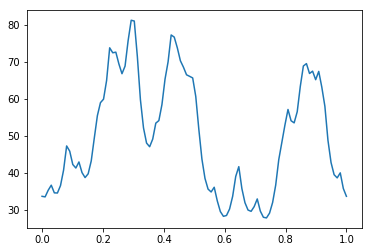

In [4]:
%matplotlib inline 
# whenever you plot anything via matplotlib in jupyter, always have this in the same cell.
vfunc = np.vectorize(fsubk) # vectorizes the function so it could take the vector of x values and spit out a vector.
x = np.linspace(0,0.9999999999999,100) # vector of x values: generates a vector of 300 numbers between 0 and 1
y = vfunc(x) # for every entry in the vector of x values, call the function that many times.
plt.plot(x,y) # plots it via matplotlib.pyplot (alias plt as seen when importing) 
plt.show() # makes the plot visible (jupyter doesn't need this command really)

In [12]:
print(len(somelist)) # 40 term 1's + 40 term 2's + 40*(conditional term) = 120, exactly what we want.

120


## A failed attempt 
I tried using binary_function which uses fortran -- it's supposed to make it work hundreds of times faster, but instead it doesn't. Tough nut to crack. Part II tba since I'm working to make it faster. 

In [13]:
anotherlist =[]

u = symbols('u')
sigma = 0.05

def fk(t0):
    anotherlist.clear()
    expr1 = exp((u-t0)/(sigma/sqrt(2)))*nsum(lambda k: exp(-k/(sigma/sqrt(2))),[1,inf])
    expr2 = exp((t0-u)/(sigma/sqrt(2)))*nsum(lambda k: exp(-k/(sigma/sqrt(2))),[1,inf])
    f1 = binary_function('f1',expr1)
    f2 = binary_function('f2',expr2)
    f1a = lambdify(u,f1(u),'numpy')
    f2b = lambdify(u,f2(u),'numpy')
    f1aa = np.vectorize(f1a)
    f2bb = np.vectorize(f2b)
    A = np.sum(f1aa(np.asarray(ulist)))
    B = np.sum(f2bb(np.asarray(ulist)))
    for i in range(0,len(ulist)):
        if t0 >= ulist[i]:
            anotherlist.append(float(exp((ulist[i]-t0)/(sigma/sqrt(2)))))
        else:
            anotherlist.append(float(exp((t0-ulist[i])/(sigma/sqrt(2)))))
    return float((float(np.sum(anotherlist))+float(A)+float(B))*(1/(sigma*sqrt(2)))+10)

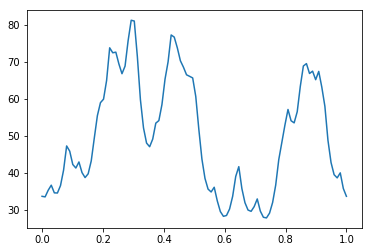

In [14]:
%matplotlib inline
vfunc1 = np.vectorize(fk)
x = np.linspace(0,1,100)
y = vfunc1(x)
plt.plot(x,y) 
plt.show()

## A third attempt
